# Learning Kalman filter parameters 

In [95]:
# includes
import numpy as np
from time import time
import scipy.stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import unique_labels
from filterpy.kalman import KalmanFilter
import sklearn.metrics
import matplotlib.pyplot as plt
from pykalman import KalmanFilter as KFEM

In [165]:
# load dataset
import csv
X = []
y = []
with open('./data/data9.csv') as csvfile:
    streamreader = csv.reader(csvfile, delimiter=";")
    i = 0
    for row in streamreader:
        #print(row[0], row[1], row[2], row[3])
        if i > 0:
            X.append([float(row[1])])
            #print(row[2])
            if row[2] == 'False':
                y.append(0);
            else:
                y.append(1);
            
        i = i + 1
        
X = np.array(X)
y = np.array(y)

In [166]:
class KalmanAOTSClassifier(BaseEstimator, ClassifierMixin):
    scoring = "accuracy"
    p_fact = 1
    r_fact = 1
    q_fact = 1
    
    Fn = 2
    Hn = 2
    
    def __init__(self, p_fact=3., r_fact=30., q_fact=0.0000015):
        self.p_fact = p_fact
        self.r_fact = r_fact
        self.q_fact = q_fact
        
        # init Kalman filter
        self.kf = KalmanFilter(self.Fn, self.Hn)        
        # initial hidden state
        self.kf.x = np.array([[ 0.03247099],[ 0.09944176]]);
        # initial transition matrix
        self.kf.F = np.array([[1., 1.], [0., 1.]]);
        # initial measurements function
        self.kf.H = np.array([[1., 0.]]);
        
    def EMoptimization(self, X):
        # init Kalman filter
        self.kf = KalmanFilter(self.Fn, self.Hn)        
        # initial hidden state
        self.kf.x = np.array([[ 0.03247099],[ 0.09944176]]);
        # initial transition matrix
        self.kf.F = np.array([[1., 1.], [0., 1.]]);
        # initial measurements function
        self.kf.H = np.array([[1., 0.]]);
        
        # perform EM expectation minimization for Kalman Filter
        lkf = KFEM(transition_matrices = self.kf.F, observation_matrices = self.kf.H)
        # print(self.kf.F, self.kf.H)
        # flatten X for em
        Xflat = np.ndarray.flatten(X)
        #print(Xflat)
        lkf.em(Xflat, n_iter = 1)

        self.EM_initialstate = lkf.initial_state_mean
        self.EM_P = lkf.transition_covariance
        self.EM_R = lkf.observation_covariance
        self.EM_Q = lkf.initial_state_covariance
        
        
    def fit(self, X, y):
        if 'EM_P' in locals():
            print("Exists")
        else:
            #print("EM was not yet run")
            self.EMoptimization(X)
                    
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # covariance matrix
        self.kf.P = self.EM_P * self.p_fact # kf.P *= 3;
        # state uncertainty
        self.kf.R = self.EM_R * self.r_fact # kf.R = 1;
        self.kf.Q = self.EM_Q * self.q_fact # kf.Q = np.array([[0.0001, 0.0005], [0.0005, 0.0005]])

        # intial state
        self.kf.x = self.EM_initialstate

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"p_fact": self.p_fact, "r_fact": self.r_fact, "q_fact": self.q_fact }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self    
    
    def predict(self, X):
        print("Predict is run")
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        #X = check_array(X)
        self.ypredicted = []
        
        for m in X:
            m = m[0]
            self.kf.predict();
            y = self.kf.x[0] + self.kf.x[1] * 0.01 # hardcoded step (!)
            e = self.kf.P[0, 0]
            
            error = 0
            if (m < y - e):
                #self.kf.P *= 2;
                error = 1
            if (m > y + e):
                #self.kf.P *= 2;
                error = 1
            
            if error == 0:
                self.kf.update(m)
            
            #print(m, y, e, error)
            self.ypredicted.append(error)

        return self.ypredicted
    
    def score(self, X, y_true):
        ly = self.predict(X);
        score = sklearn.metrics.f1_score(y_true, ly)
        # print(sklearn.metrics.classification_report(y_true, y))
        print("Score: ", score, "    p, r, q", self.p_fact, self.r_fact, self.q_fact)
        return score
        


param_dist = {
    "p_fact": scipy.stats.expon(scale = 100),
    "r_fact": scipy.stats.expon(scale = 100),
    "q_fact": scipy.stats.expon(scale = 100)
}

param_dist = {
    "p_fact": [0.03, 0.1, 0.3, 1., 3., 10, 30, 100],
    "r_fact": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10, 30],
    "q_fact": [0.00001, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]
}

clf2 = KalmanAOTSClassifier();
#clf2.EMoptimization(X[1:10000]);
n_iter_search = 1
random_search = RandomizedSearchCV(clf2, param_distributions=param_dist, n_iter=n_iter_search)
random_search = GridSearchCV(clf2, param_grid=param_dist)
random_search.fit(X[1:2000], y[1:2000])
clf2.fit(X, y)


Predict is run
Score:  0.0120663650075     p, r, q 0.03 0.001 1e-05
Predict is run
Score:  0.0107115531752     p, r, q 0.03 0.001 1e-05
Predict is run
Score:  0.0121580547112     p, r, q 0.03 0.001 1e-05
Predict is run
Score:  0.00912547528517     p, r, q 0.03 0.001 1e-05
Predict is run
Score:  0.00607902735562     p, r, q 0.03 0.001 1e-05
Predict is run
Score:  0.0121673003802     p, r, q 0.03 0.001 1e-05
Predict is run
Score:  0.0120481927711     p, r, q 0.03 0.003 1e-05
Predict is run
Score:  0.010760953113     p, r, q 0.03 0.003 1e-05
Predict is run
Score:  0.0121212121212     p, r, q 0.03 0.003 1e-05
Predict is run
Score:  0.0106707317073     p, r, q 0.03 0.003 1e-05
Predict is run
Score:  0.00608828006088     p, r, q 0.03 0.003 1e-05
Predict is run
Score:  0.0122230710466     p, r, q 0.03 0.003 1e-05
Predict is run
Score:  0.0121765601218     p, r, q 0.03 0.01 1e-05
Predict is run
Score:  0.00922367409685     p, r, q 0.03 0.01 1e-05
Predict is run
Score:  0.0123076923077     p, r

Predict is run
Score:  0.00947867298578     p, r, q 0.03 0.001 0.0003
Predict is run
Score:  0.0109976433621     p, r, q 0.03 0.001 0.0003
Predict is run
Score:  0.0125588697017     p, r, q 0.03 0.003 0.0003
Predict is run
Score:  0.00788022064618     p, r, q 0.03 0.003 0.0003
Predict is run
Score:  0.0125786163522     p, r, q 0.03 0.003 0.0003
Predict is run
Score:  0.0111376292761     p, r, q 0.03 0.003 0.0003
Predict is run
Score:  0.00953895071542     p, r, q 0.03 0.003 0.0003
Predict is run
Score:  0.00944138473643     p, r, q 0.03 0.003 0.0003
Predict is run
Score:  0.0125588697017     p, r, q 0.03 0.01 0.0003
Predict is run
Score:  0.0079554494829     p, r, q 0.03 0.01 0.0003
Predict is run
Score:  0.0126782884311     p, r, q 0.03 0.01 0.0003
Predict is run
Score:  0.0111731843575     p, r, q 0.03 0.01 0.0003
Predict is run
Score:  0.00966183574879     p, r, q 0.03 0.01 0.0003
Predict is run
Score:  0.00948616600791     p, r, q 0.03 0.01 0.0003
Predict is run
Score:  0.0128     

Predict is run
Score:  0.0133779264214     p, r, q 0.03 0.003 0.003
Predict is run
Score:  0.0101095197978     p, r, q 0.03 0.003 0.003
Predict is run
Score:  0.00675675675676     p, r, q 0.03 0.003 0.003
Predict is run
Score:  0.0134453781513     p, r, q 0.03 0.003 0.003
Predict is run
Score:  0.010152284264     p, r, q 0.03 0.01 0.003
Predict is run
Score:  0.0118644067797     p, r, q 0.03 0.01 0.003
Predict is run
Score:  0.0134453781513     p, r, q 0.03 0.01 0.003
Predict is run
Score:  0.00851063829787     p, r, q 0.03 0.01 0.003
Predict is run
Score:  0.00673400673401     p, r, q 0.03 0.01 0.003
Predict is run
Score:  0.0118343195266     p, r, q 0.03 0.01 0.003
Predict is run
Score:  0.0136286201022     p, r, q 0.03 0.03 0.003
Predict is run
Score:  0.00850340136054     p, r, q 0.03 0.03 0.003
Predict is run
Score:  0.0139616055846     p, r, q 0.03 0.03 0.003
Predict is run
Score:  0.0121212121212     p, r, q 0.03 0.03 0.003
Predict is run
Score:  0.00699300699301     p, r, q 0.0

C:\Users\kkenda\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Score:  0.0     p, r, q 0.03 30 0.01
Predict is run
Score:  0.0     p, r, q 0.03 30 0.01
Predict is run
Score:  0.222222222222     p, r, q 0.03 30 0.01
Predict is run
Score:  0.0153550863724     p, r, q 0.03 0.001 0.03
Predict is run
Score:  0.0115163147793     p, r, q 0.03 0.001 0.03
Predict is run
Score:  0.0152380952381     p, r, q 0.03 0.001 0.03
Predict is run
Score:  0.0115163147793     p, r, q 0.03 0.001 0.03
Predict is run
Score:  0.00764818355641     p, r, q 0.03 0.001 0.03
Predict is run
Score:  0.0153110047847     p, r, q 0.03 0.001 0.03
Predict is run
Score:  0.0152963671128     p, r, q 0.03 0.003 0.03
Predict is run
Score:  0.0115273775216     p, r, q 0.03 0.003 0.03
Predict is run
Score:  0.0152671755725     p, r, q 0.03 0.003 0.03
Predict is run
Score:  0.0115163147793     p, r, q 0.03 0.003 0.03
Predict is run
Score:  0.00766283524904     p, r, q 0.03 0.003 0.03
Predict is run
Score:  0.0153110047847     p, r, q 0.03 0.003 0.03
Predict is run
Score:  0.0153550863724    

Predict is run
Score:  0.00934579439252     p, r, q 0.1 0.001 0.0001
Predict is run
Score:  0.01246105919     p, r, q 0.1 0.001 0.0001
Predict is run
Score:  0.00928792569659     p, r, q 0.1 0.003 0.0001
Predict is run
Score:  0.0109119251754     p, r, q 0.1 0.003 0.0001
Predict is run
Score:  0.00927357032457     p, r, q 0.1 0.003 0.0001
Predict is run
Score:  0.0108527131783     p, r, q 0.1 0.003 0.0001
Predict is run
Score:  0.00934579439252     p, r, q 0.1 0.003 0.0001
Predict is run
Score:  0.0109034267913     p, r, q 0.1 0.003 0.0001
Predict is run
Score:  0.0124031007752     p, r, q 0.1 0.01 0.0001
Predict is run
Score:  0.00934579439252     p, r, q 0.1 0.01 0.0001
Predict is run
Score:  0.0062015503876     p, r, q 0.1 0.01 0.0001
Predict is run
Score:  0.0109119251754     p, r, q 0.1 0.01 0.0001
Predict is run
Score:  0.00944881889764     p, r, q 0.1 0.01 0.0001
Predict is run
Score:  0.00930954228084     p, r, q 0.1 0.01 0.0001
Predict is run
Score:  0.0125786163522     p, r, 

Predict is run
Score:  0.0129449838188     p, r, q 0.1 0.003 0.001
Predict is run
Score:  0.00981996726678     p, r, q 0.1 0.003 0.001
Predict is run
Score:  0.00978792822186     p, r, q 0.1 0.003 0.001
Predict is run
Score:  0.00978792822186     p, r, q 0.1 0.003 0.001
Predict is run
Score:  0.0132669983416     p, r, q 0.1 0.01 0.001
Predict is run
Score:  0.0115226337449     p, r, q 0.1 0.01 0.001
Predict is run
Score:  0.0130081300813     p, r, q 0.1 0.01 0.001
Predict is run
Score:  0.00826446280992     p, r, q 0.1 0.01 0.001
Predict is run
Score:  0.00328947368421     p, r, q 0.1 0.01 0.001
Predict is run
Score:  0.013104013104     p, r, q 0.1 0.01 0.001
Predict is run
Score:  0.00996677740864     p, r, q 0.1 0.03 0.001
Predict is run
Score:  0.0115131578947     p, r, q 0.1 0.03 0.001
Predict is run
Score:  0.013201320132     p, r, q 0.1 0.03 0.001
Predict is run
Score:  0.00995850622407     p, r, q 0.1 0.03 0.001
Predict is run
Score:  0.00990099009901     p, r, q 0.1 0.03 0.001


Predict is run
Score:  0.00716845878136     p, r, q 0.1 0.01 0.01
Predict is run
Score:  0.0124777183601     p, r, q 0.1 0.01 0.01
Predict is run
Score:  0.0145190562613     p, r, q 0.1 0.03 0.01
Predict is run
Score:  0.0127620783956     p, r, q 0.1 0.03 0.01
Predict is run
Score:  0.0143884892086     p, r, q 0.1 0.03 0.01
Predict is run
Score:  0.0110192837466     p, r, q 0.1 0.03 0.01
Predict is run
Score:  0.0111111111111     p, r, q 0.1 0.03 0.01
Predict is run
Score:  0.0126696832579     p, r, q 0.1 0.03 0.01
Predict is run
Score:  0.015444015444     p, r, q 0.1 0.1 0.01
Predict is run
Score:  0.0132450331126     p, r, q 0.1 0.1 0.01
Predict is run
Score:  0.0148423005566     p, r, q 0.1 0.1 0.01
Predict is run
Score:  0.0132827324478     p, r, q 0.1 0.1 0.01
Predict is run
Score:  0.0113636363636     p, r, q 0.1 0.1 0.01
Predict is run
Score:  0.0151085930123     p, r, q 0.1 0.1 0.01
Predict is run
Score:  0.0126315789474     p, r, q 0.1 0.3 0.01
Predict is run
Score:  0.0144777

Predict is run
Score:  0.0127388535032     p, r, q 0.3 0.1 1e-05
Predict is run
Score:  0.0110323089046     p, r, q 0.3 0.1 1e-05
Predict is run
Score:  0.00940438871473     p, r, q 0.3 0.1 1e-05
Predict is run
Score:  0.01246105919     p, r, q 0.3 0.1 1e-05
Predict is run
Score:  0.00943396226415     p, r, q 0.3 0.3 1e-05
Predict is run
Score:  0.0113177041229     p, r, q 0.3 0.3 1e-05
Predict is run
Score:  0.0130718954248     p, r, q 0.3 0.3 1e-05
Predict is run
Score:  0.011466011466     p, r, q 0.3 0.3 1e-05
Predict is run
Score:  0.00983606557377     p, r, q 0.3 0.3 1e-05
Predict is run
Score:  0.0112     p, r, q 0.3 0.3 1e-05
Predict is run
Score:  0.00326264274062     p, r, q 0.3 1.0 1e-05
Predict is run
Score:  0.0120793787748     p, r, q 0.3 1.0 1e-05
Predict is run
Score:  0.013698630137     p, r, q 0.3 1.0 1e-05
Predict is run
Score:  0.0102739726027     p, r, q 0.3 1.0 1e-05
Predict is run
Score:  0.0103626943005     p, r, q 0.3 1.0 1e-05
Predict is run
Score:  0.011854360

Predict is run
Score:  0.00993377483444     p, r, q 0.3 0.3 0.0003
Predict is run
Score:  0.0124888492417     p, r, q 0.3 0.3 0.0003
Predict is run
Score:  0.0105078809107     p, r, q 0.3 0.3 0.0003
Predict is run
Score:  0.0121107266436     p, r, q 0.3 0.3 0.0003
Predict is run
Score:  0.014953271028     p, r, q 0.3 1.0 0.0003
Predict is run
Score:  0.0133971291866     p, r, q 0.3 1.0 0.0003
Predict is run
Score:  0.0148698884758     p, r, q 0.3 1.0 0.0003
Predict is run
Score:  0.0134486071085     p, r, q 0.3 1.0 0.0003
Predict is run
Score:  0.0116959064327     p, r, q 0.3 1.0 0.0003
Predict is run
Score:  0.0151515151515     p, r, q 0.3 1.0 0.0003
Predict is run
Score:  0.0181405895692     p, r, q 0.3 3.0 0.0003
Predict is run
Score:  0.017199017199     p, r, q 0.3 3.0 0.0003
Predict is run
Score:  0.0184331797235     p, r, q 0.3 3.0 0.0003
Predict is run
Score:  0.0168269230769     p, r, q 0.3 3.0 0.0003
Predict is run
Score:  0.0142857142857     p, r, q 0.3 3.0 0.0003
Predict is 

Predict is run
Score:  0.0178173719376     p, r, q 0.3 1.0 0.003
Predict is run
Score:  0.0142687277051     p, r, q 0.3 1.0 0.003
Predict is run
Score:  0.0141509433962     p, r, q 0.3 1.0 0.003
Predict is run
Score:  0.0165680473373     p, r, q 0.3 1.0 0.003
Predict is run
Score:  0.0306513409962     p, r, q 0.3 3.0 0.003
Predict is run
Score:  0.0244755244755     p, r, q 0.3 3.0 0.003
Predict is run
Score:  0.0281690140845     p, r, q 0.3 3.0 0.003
Predict is run
Score:  0.0246478873239     p, r, q 0.3 3.0 0.003
Predict is run
Score:  0.020618556701     p, r, q 0.3 3.0 0.003
Predict is run
Score:  0.0285714285714     p, r, q 0.3 3.0 0.003
Predict is run
Score:  0.0655737704918     p, r, q 0.3 10 0.003
Predict is run
Score:  0.0833333333333     p, r, q 0.3 10 0.003
Predict is run
Score:  0.0888888888889     p, r, q 0.3 10 0.003
Predict is run
Score:  0.0731707317073     p, r, q 0.3 10 0.003
Predict is run
Score:  0.063829787234     p, r, q 0.3 10 0.003
Predict is run
Score:  0.0789473

Score:  0.0498220640569     p, r, q 0.3 3.0 0.03
Predict is run
Score:  0.25     p, r, q 0.3 10 0.03
Predict is run
Score:  0.454545454545     p, r, q 0.3 10 0.03
Predict is run
Score:  0.4     p, r, q 0.3 10 0.03
Predict is run
Score:  0.315789473684     p, r, q 0.3 10 0.03
Predict is run
Score:  0.307692307692     p, r, q 0.3 10 0.03
Predict is run
Score:  0.4     p, r, q 0.3 10 0.03
Predict is run
Score:  0.0     p, r, q 0.3 30 0.03
Predict is run
Score:  0.0     p, r, q 0.3 30 0.03
Predict is run
Score:  0.333333333333     p, r, q 0.3 30 0.03
Predict is run
Score:  0.0     p, r, q 0.3 30 0.03
Predict is run
Score:  0.0     p, r, q 0.3 30 0.03
Predict is run
Score:  0.222222222222     p, r, q 0.3 30 0.03
Predict is run
Score:  0.0119940029985     p, r, q 1.0 0.001 1e-05
Predict is run
Score:  0.010662604722     p, r, q 1.0 0.001 1e-05
Predict is run
Score:  0.0120663650075     p, r, q 1.0 0.001 1e-05
Predict is run
Score:  0.0107033639144     p, r, q 1.0 0.001 1e-05
Predict is run
S

Score:  0.0242424242424     p, r, q 1.0 10 0.0001
Predict is run
Score:  0.0631578947368     p, r, q 1.0 30 0.0001
Predict is run
Score:  0.0497925311203     p, r, q 1.0 30 0.0001
Predict is run
Score:  0.0592592592593     p, r, q 1.0 30 0.0001
Predict is run
Score:  0.0588235294118     p, r, q 1.0 30 0.0001
Predict is run
Score:  0.0550458715596     p, r, q 1.0 30 0.0001
Predict is run
Score:  0.0625     p, r, q 1.0 30 0.0001
Predict is run
Score:  0.00943396226415     p, r, q 1.0 0.001 0.0003
Predict is run
Score:  0.00790513833992     p, r, q 1.0 0.001 0.0003
Predict is run
Score:  0.0126382306477     p, r, q 1.0 0.001 0.0003
Predict is run
Score:  0.0111731843575     p, r, q 1.0 0.001 0.0003
Predict is run
Score:  0.00958466453674     p, r, q 1.0 0.001 0.0003
Predict is run
Score:  0.00944138473643     p, r, q 1.0 0.001 0.0003
Predict is run
Score:  0.01261829653     p, r, q 1.0 0.003 0.0003
Predict is run
Score:  0.0111464968153     p, r, q 1.0 0.003 0.0003
Predict is run
Score:  

Score:  0.4     p, r, q 1.0 30 0.001
Predict is run
Score:  0.0134453781513     p, r, q 1.0 0.001 0.003
Predict is run
Score:  0.010067114094     p, r, q 1.0 0.001 0.003
Predict is run
Score:  0.0133555926544     p, r, q 1.0 0.001 0.003
Predict is run
Score:  0.0101095197978     p, r, q 1.0 0.001 0.003
Predict is run
Score:  0.010067114094     p, r, q 1.0 0.001 0.003
Predict is run
Score:  0.0117056856187     p, r, q 1.0 0.001 0.003
Predict is run
Score:  0.0136054421769     p, r, q 1.0 0.003 0.003
Predict is run
Score:  0.00838926174497     p, r, q 1.0 0.003 0.003
Predict is run
Score:  0.0133779264214     p, r, q 1.0 0.003 0.003
Predict is run
Score:  0.0101608806097     p, r, q 1.0 0.003 0.003
Predict is run
Score:  0.0101867572156     p, r, q 1.0 0.003 0.003
Predict is run
Score:  0.0134453781513     p, r, q 1.0 0.003 0.003
Predict is run
Score:  0.0102564102564     p, r, q 1.0 0.01 0.003
Predict is run
Score:  0.0118644067797     p, r, q 1.0 0.01 0.003
Predict is run
Score:  0.013

Predict is run
Score:  0.0153256704981     p, r, q 1.0 0.003 0.03
Predict is run
Score:  0.0115163147793     p, r, q 1.0 0.003 0.03
Predict is run
Score:  0.00766283524904     p, r, q 1.0 0.003 0.03
Predict is run
Score:  0.0153110047847     p, r, q 1.0 0.003 0.03
Predict is run
Score:  0.0153550863724     p, r, q 1.0 0.01 0.03
Predict is run
Score:  0.0116845180136     p, r, q 1.0 0.01 0.03
Predict is run
Score:  0.0156555772994     p, r, q 1.0 0.01 0.03
Predict is run
Score:  0.0115606936416     p, r, q 1.0 0.01 0.03
Predict is run
Score:  0.00772200772201     p, r, q 1.0 0.01 0.03
Predict is run
Score:  0.015503875969     p, r, q 1.0 0.01 0.03
Predict is run
Score:  0.0157790927022     p, r, q 1.0 0.03 0.03
Predict is run
Score:  0.0137795275591     p, r, q 1.0 0.03 0.03
Predict is run
Score:  0.0155339805825     p, r, q 1.0 0.03 0.03
Predict is run
Score:  0.0137254901961     p, r, q 1.0 0.03 0.03
Predict is run
Score:  0.0117878192534     p, r, q 1.0 0.03 0.03
Predict is run
Score

Predict is run
Score:  0.00947867298578     p, r, q 3.0 0.01 0.0001
Predict is run
Score:  0.00931677018634     p, r, q 3.0 0.01 0.0001
Predict is run
Score:  0.0125588697017     p, r, q 3.0 0.03 0.0001
Predict is run
Score:  0.00957701516361     p, r, q 3.0 0.03 0.0001
Predict is run
Score:  0.01261829653     p, r, q 3.0 0.03 0.0001
Predict is run
Score:  0.0111376292761     p, r, q 3.0 0.03 0.0001
Predict is run
Score:  0.00956937799043     p, r, q 3.0 0.03 0.0001
Predict is run
Score:  0.0125490196078     p, r, q 3.0 0.03 0.0001
Predict is run
Score:  0.0127591706539     p, r, q 3.0 0.1 0.0001
Predict is run
Score:  0.00976403580146     p, r, q 3.0 0.1 0.0001
Predict is run
Score:  0.0128824476651     p, r, q 3.0 0.1 0.0001
Predict is run
Score:  0.0112812248187     p, r, q 3.0 0.1 0.0001
Predict is run
Score:  0.00990099009901     p, r, q 3.0 0.1 0.0001
Predict is run
Score:  0.0128824476651     p, r, q 3.0 0.1 0.0001
Predict is run
Score:  0.012987012987     p, r, q 3.0 0.3 0.0001

Predict is run
Score:  0.0133555926544     p, r, q 3.0 0.03 0.001
Predict is run
Score:  0.00999167360533     p, r, q 3.0 0.03 0.001
Predict is run
Score:  0.00993377483444     p, r, q 3.0 0.03 0.001
Predict is run
Score:  0.0115702479339     p, r, q 3.0 0.03 0.001
Predict is run
Score:  0.00682593856655     p, r, q 3.0 0.1 0.001
Predict is run
Score:  0.0085910652921     p, r, q 3.0 0.1 0.001
Predict is run
Score:  0.0136286201022     p, r, q 3.0 0.1 0.001
Predict is run
Score:  0.00515021459227     p, r, q 3.0 0.1 0.001
Predict is run
Score:  0.00683760683761     p, r, q 3.0 0.1 0.001
Predict is run
Score:  0.0119555935098     p, r, q 3.0 0.1 0.001
Predict is run
Score:  0.0112781954887     p, r, q 3.0 0.3 0.001
Predict is run
Score:  0.0128558310376     p, r, q 3.0 0.3 0.001
Predict is run
Score:  0.0145454545455     p, r, q 3.0 0.3 0.001
Predict is run
Score:  0.00921658986175     p, r, q 3.0 0.3 0.001
Predict is run
Score:  0.00738007380074     p, r, q 3.0 0.3 0.001
Predict is run

Predict is run
Score:  0.0113421550095     p, r, q 3.0 0.1 0.01
Predict is run
Score:  0.0151085930123     p, r, q 3.0 0.1 0.01
Predict is run
Score:  0.0126050420168     p, r, q 3.0 0.3 0.01
Predict is run
Score:  0.0144777662875     p, r, q 3.0 0.3 0.01
Predict is run
Score:  0.0160965794769     p, r, q 3.0 0.3 0.01
Predict is run
Score:  0.014553014553     p, r, q 3.0 0.3 0.01
Predict is run
Score:  0.0125     p, r, q 3.0 0.3 0.01
Predict is run
Score:  0.0163766632549     p, r, q 3.0 0.3 0.01
Predict is run
Score:  0.0224089635854     p, r, q 3.0 1.0 0.01
Predict is run
Score:  0.0188172043011     p, r, q 3.0 1.0 0.01
Predict is run
Score:  0.0209973753281     p, r, q 3.0 1.0 0.01
Predict is run
Score:  0.0191256830601     p, r, q 3.0 1.0 0.01
Predict is run
Score:  0.016348773842     p, r, q 3.0 1.0 0.01
Predict is run
Score:  0.0215924426451     p, r, q 3.0 1.0 0.01
Predict is run
Score:  0.0437158469945     p, r, q 3.0 3.0 0.01
Predict is run
Score:  0.0324825986079     p, r, q 

Predict is run
Score:  0.0106571936057     p, r, q 10 1.0 1e-05
Predict is run
Score:  0.0117056856187     p, r, q 10 1.0 1e-05
Predict is run
Score:  0.0113421550095     p, r, q 10 3.0 1e-05
Predict is run
Score:  0.0137120470127     p, r, q 10 3.0 1e-05
Predict is run
Score:  0.015625     p, r, q 10 3.0 1e-05
Predict is run
Score:  0.0113421550095     p, r, q 10 3.0 1e-05
Predict is run
Score:  0.0121703853955     p, r, q 10 3.0 1e-05
Predict is run
Score:  0.0129990714949     p, r, q 10 3.0 1e-05
Predict is run
Score:  0.0187353629977     p, r, q 10 10 1e-05
Predict is run
Score:  0.017305315204     p, r, q 10 10 1e-05
Predict is run
Score:  0.0189125295508     p, r, q 10 10 1e-05
Predict is run
Score:  0.0164126611958     p, r, q 10 10 1e-05
Predict is run
Score:  0.0149253731343     p, r, q 10 10 1e-05
Predict is run
Score:  0.0184331797235     p, r, q 10 10 1e-05
Predict is run
Score:  0.0298507462687     p, r, q 10 30 1e-05
Predict is run
Score:  0.0266159695817     p, r, q 10 3

Predict is run
Score:  0.0153452685422     p, r, q 10 3.0 0.0003
Predict is run
Score:  0.0181405895692     p, r, q 10 3.0 0.0003
Predict is run
Score:  0.036866359447     p, r, q 10 10 0.0003
Predict is run
Score:  0.0247933884298     p, r, q 10 10 0.0003
Predict is run
Score:  0.030534351145     p, r, q 10 10 0.0003
Predict is run
Score:  0.0297239915074     p, r, q 10 10 0.0003
Predict is run
Score:  0.0279069767442     p, r, q 10 10 0.0003
Predict is run
Score:  0.0318725099602     p, r, q 10 10 0.0003
Predict is run
Score:  0.176470588235     p, r, q 10 30 0.0003
Predict is run
Score:  0.145833333333     p, r, q 10 30 0.0003
Predict is run
Score:  0.131147540984     p, r, q 10 30 0.0003
Predict is run
Score:  0.134831460674     p, r, q 10 30 0.0003
Predict is run
Score:  0.130434782609     p, r, q 10 30 0.0003
Predict is run
Score:  0.138613861386     p, r, q 10 30 0.0003
Predict is run
Score:  0.0129449838188     p, r, q 10 0.001 0.001
Predict is run
Score:  0.00970873786408     

Predict is run
Score:  0.0     p, r, q 10 30 0.003
Predict is run
Score:  0.666666666667     p, r, q 10 30 0.003
Predict is run
Score:  0.857142857143     p, r, q 10 30 0.003
Predict is run
Score:  0.5     p, r, q 10 30 0.003
Predict is run
Score:  0.666666666667     p, r, q 10 30 0.003
Predict is run
Score:  0.5     p, r, q 10 30 0.003
Predict is run
Score:  0.0105633802817     p, r, q 10 0.001 0.01
Predict is run
Score:  0.0106571936057     p, r, q 10 0.001 0.01
Predict is run
Score:  0.0106382978723     p, r, q 10 0.001 0.01
Predict is run
Score:  0.00892857142857     p, r, q 10 0.001 0.01
Predict is run
Score:  0.00713012477718     p, r, q 10 0.001 0.01
Predict is run
Score:  0.0106571936057     p, r, q 10 0.001 0.01
Predict is run
Score:  0.0105448154657     p, r, q 10 0.003 0.01
Predict is run
Score:  0.010752688172     p, r, q 10 0.003 0.01
Predict is run
Score:  0.0142602495544     p, r, q 10 0.003 0.01
Predict is run
Score:  0.0089928057554     p, r, q 10 0.003 0.01
Predict is

Predict is run
Score:  0.00914634146341     p, r, q 30 0.003 1e-05
Predict is run
Score:  0.00927357032457     p, r, q 30 0.003 1e-05
Predict is run
Score:  0.00918836140888     p, r, q 30 0.003 1e-05
Predict is run
Score:  0.0122511485452     p, r, q 30 0.003 1e-05
Predict is run
Score:  0.0121951219512     p, r, q 30 0.01 1e-05
Predict is run
Score:  0.00917431192661     p, r, q 30 0.01 1e-05
Predict is run
Score:  0.012213740458     p, r, q 30 0.01 1e-05
Predict is run
Score:  0.00921658986175     p, r, q 30 0.01 1e-05
Predict is run
Score:  0.00927357032457     p, r, q 30 0.01 1e-05
Predict is run
Score:  0.0122417750574     p, r, q 30 0.01 1e-05
Predict is run
Score:  0.0122887864823     p, r, q 30 0.03 1e-05
Predict is run
Score:  0.00923787528868     p, r, q 30 0.03 1e-05
Predict is run
Score:  0.00923076923077     p, r, q 30 0.03 1e-05
Predict is run
Score:  0.0107775211701     p, r, q 30 0.03 1e-05
Predict is run
Score:  0.00924499229584     p, r, q 30 0.03 1e-05
Predict is ru

Predict is run
Score:  0.00955414012739     p, r, q 30 0.01 0.0003
Predict is run
Score:  0.0111022997621     p, r, q 30 0.01 0.0003
Predict is run
Score:  0.0130505709625     p, r, q 30 0.03 0.0003
Predict is run
Score:  0.0113268608414     p, r, q 30 0.03 0.0003
Predict is run
Score:  0.0128410914928     p, r, q 30 0.03 0.0003
Predict is run
Score:  0.0113360323887     p, r, q 30 0.03 0.0003
Predict is run
Score:  0.00963081861958     p, r, q 30 0.03 0.0003
Predict is run
Score:  0.0111821086262     p, r, q 30 0.03 0.0003
Predict is run
Score:  0.0132669983416     p, r, q 30 0.1 0.0003
Predict is run
Score:  0.00992555831266     p, r, q 30 0.1 0.0003
Predict is run
Score:  0.0134003350084     p, r, q 30 0.1 0.0003
Predict is run
Score:  0.0116959064327     p, r, q 30 0.1 0.0003
Predict is run
Score:  0.00671140939597     p, r, q 30 0.1 0.0003
Predict is run
Score:  0.0115226337449     p, r, q 30 0.1 0.0003
Predict is run
Score:  0.014652014652     p, r, q 30 0.3 0.0003
Predict is run

Predict is run
Score:  0.0107334525939     p, r, q 30 0.1 0.003
Predict is run
Score:  0.0123565754634     p, r, q 30 0.1 0.003
Predict is run
Score:  0.0141093474427     p, r, q 30 0.1 0.003
Predict is run
Score:  0.0125111706881     p, r, q 30 0.1 0.003
Predict is run
Score:  0.0106007067138     p, r, q 30 0.1 0.003
Predict is run
Score:  0.0143755615454     p, r, q 30 0.1 0.003
Predict is run
Score:  0.0116279069767     p, r, q 30 0.3 0.003
Predict is run
Score:  0.0134874759152     p, r, q 30 0.3 0.003
Predict is run
Score:  0.0149253731343     p, r, q 30 0.3 0.003
Predict is run
Score:  0.0114613180516     p, r, q 30 0.3 0.003
Predict is run
Score:  0.011811023622     p, r, q 30 0.3 0.003
Predict is run
Score:  0.0135004821601     p, r, q 30 0.3 0.003
Predict is run
Score:  0.014742014742     p, r, q 30 1.0 0.003
Predict is run
Score:  0.0162790697674     p, r, q 30 1.0 0.003
Predict is run
Score:  0.0176991150442     p, r, q 30 1.0 0.003
Predict is run
Score:  0.0142687277051    

Score:  0.0185830429733     p, r, q 30 0.3 0.03
Predict is run
Score:  0.020979020979     p, r, q 30 1.0 0.03
Predict is run
Score:  0.0192616372392     p, r, q 30 1.0 0.03
Predict is run
Score:  0.0252365930599     p, r, q 30 1.0 0.03
Predict is run
Score:  0.0162337662338     p, r, q 30 1.0 0.03
Predict is run
Score:  0.0128205128205     p, r, q 30 1.0 0.03
Predict is run
Score:  0.0230263157895     p, r, q 30 1.0 0.03
Predict is run
Score:  0.0504201680672     p, r, q 30 3.0 0.03
Predict is run
Score:  0.0413793103448     p, r, q 30 3.0 0.03
Predict is run
Score:  0.0536912751678     p, r, q 30 3.0 0.03
Predict is run
Score:  0.0353356890459     p, r, q 30 3.0 0.03
Predict is run
Score:  0.0268456375839     p, r, q 30 3.0 0.03
Predict is run
Score:  0.0498220640569     p, r, q 30 3.0 0.03
Predict is run
Score:  0.285714285714     p, r, q 30 10 0.03
Predict is run
Score:  0.454545454545     p, r, q 30 10 0.03
Predict is run
Score:  0.428571428571     p, r, q 30 10 0.03
Predict is run

Predict is run
Score:  0.0178173719376     p, r, q 100 3.0 0.0001
Predict is run
Score:  0.012539184953     p, r, q 100 3.0 0.0001
Predict is run
Score:  0.017094017094     p, r, q 100 3.0 0.0001
Predict is run
Score:  0.0149572649573     p, r, q 100 3.0 0.0001
Predict is run
Score:  0.0132743362832     p, r, q 100 3.0 0.0001
Predict is run
Score:  0.014553014553     p, r, q 100 3.0 0.0001
Predict is run
Score:  0.0265780730897     p, r, q 100 10 0.0001
Predict is run
Score:  0.0191693290735     p, r, q 100 10 0.0001
Predict is run
Score:  0.0243161094225     p, r, q 100 10 0.0001
Predict is run
Score:  0.0221870047544     p, r, q 100 10 0.0001
Predict is run
Score:  0.0212014134276     p, r, q 100 10 0.0001
Predict is run
Score:  0.0242424242424     p, r, q 100 10 0.0001
Predict is run
Score:  0.0606060606061     p, r, q 100 30 0.0001
Predict is run
Score:  0.0497925311203     p, r, q 100 30 0.0001
Predict is run
Score:  0.0615384615385     p, r, q 100 30 0.0001
Predict is run
Score: 

Score:  0.0200286123033     p, r, q 100 3.0 0.001
Predict is run
Score:  0.0615384615385     p, r, q 100 10 0.001
Predict is run
Score:  0.0479452054795     p, r, q 100 10 0.001
Predict is run
Score:  0.0516129032258     p, r, q 100 10 0.001
Predict is run
Score:  0.046357615894     p, r, q 100 10 0.001
Predict is run
Score:  0.0413793103448     p, r, q 100 10 0.001
Predict is run
Score:  0.0542372881356     p, r, q 100 10 0.001
Predict is run
Score:  0.285714285714     p, r, q 100 30 0.001
Predict is run
Score:  0.344827586207     p, r, q 100 30 0.001
Predict is run
Score:  0.470588235294     p, r, q 100 30 0.001
Predict is run
Score:  0.25     p, r, q 100 30 0.001
Predict is run
Score:  0.285714285714     p, r, q 100 30 0.001
Predict is run
Score:  0.4     p, r, q 100 30 0.001
Predict is run
Score:  0.0132450331126     p, r, q 100 0.001 0.003
Predict is run
Score:  0.010067114094     p, r, q 100 0.001 0.003
Predict is run
Score:  0.0134907251265     p, r, q 100 0.001 0.003
Predict is

Score:  0.25     p, r, q 100 30 0.01
Predict is run
Score:  0.4     p, r, q 100 30 0.01
Predict is run
Score:  0.0     p, r, q 100 30 0.01
Predict is run
Score:  0.0     p, r, q 100 30 0.01
Predict is run
Score:  0.222222222222     p, r, q 100 30 0.01
Predict is run
Score:  0.0152671755725     p, r, q 100 0.001 0.03
Predict is run
Score:  0.0115163147793     p, r, q 100 0.001 0.03
Predict is run
Score:  0.0152963671128     p, r, q 100 0.001 0.03
Predict is run
Score:  0.0115163147793     p, r, q 100 0.001 0.03
Predict is run
Score:  0.00764818355641     p, r, q 100 0.001 0.03
Predict is run
Score:  0.0153110047847     p, r, q 100 0.001 0.03
Predict is run
Score:  0.0151515151515     p, r, q 100 0.003 0.03
Predict is run
Score:  0.0115273775216     p, r, q 100 0.003 0.03
Predict is run
Score:  0.0153256704981     p, r, q 100 0.003 0.03
Predict is run
Score:  0.0115163147793     p, r, q 100 0.003 0.03
Predict is run
Score:  0.00766283524904     p, r, q 100 0.003 0.03
Predict is run
Score

KalmanAOTSClassifier(p_fact=3.0, q_fact=1.5e-06, r_fact=30.0)

In [105]:
clf2.score(X, y)

Predict is run
Score:  0.0397801622612     p, r, q 3.0 30.0 1.5e-06


0.039780162261188162

In [59]:
# y = np.array(clf2.predict(X))
clf2.score(X, y)

Predict is run
Predict is run
0.0


0.0

In [172]:
i = 0
j = 0
for ii in range(1,30000):
    #print(a)
    a = y[ii]
    if a == 1:
        #print("T", a)
        i = i + 1
    else:
        j = j + 1
        
print(i, j)

111 29888


In [101]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
param_dist = {
    "p_fact": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10, 30],
    "r_fact": [0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10],
    "q_fact": [0.00001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
}

In [62]:
clf2 = KalmanAOTSClassifier();
n_iter_search = 1
random_search = RandomizedSearchCV(clf2, param_distributions=param_dist, n_iter=n_iter_search)
random_search.fit(X, y)

EM was not yet run
[ 0.25701406  0.40086486  0.25552201 ...,  0.11581251  0.00335706
 -0.1152928 ]
p, r, q 0.003 1.0 10
Predict is run
0.0
Predict is run
0.0
EM was not yet run
[ 0.11320182  0.03886278  0.07428549 ...,  0.11581251  0.00335706
 -0.1152928 ]
p, r, q 0.003 1.0 10
Predict is run
0.0
Predict is run
0.0
EM was not yet run
[ 0.11320182  0.03886278  0.07428549 ...,  0.48938874  0.31203997
  0.44444675]
p, r, q 0.003 1.0 10
Predict is run
0.0
Predict is run
0.0
EM was not yet run
[ 0.11320182  0.03886278  0.07428549 ...,  0.11581251  0.00335706
 -0.1152928 ]
p, r, q 0.003 1.0 10


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=KalmanAOTSClassifier(p_fact=3.0, q_fact=1.5e-06, r_fact=30.0),
          fit_params={}, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'p_fact': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30], 'r_fact': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30], 'q_fact': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [167]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.508 (std: 0.368)
Parameters: {'p_fact': 1.0, 'q_fact': 0.003, 'r_fact': 30}

Model with rank: 1
Mean validation score: 0.508 (std: 0.368)
Parameters: {'p_fact': 3.0, 'q_fact': 0.003, 'r_fact': 30}

Model with rank: 1
Mean validation score: 0.508 (std: 0.368)
Parameters: {'p_fact': 10, 'q_fact': 0.003, 'r_fact': 30}

Model with rank: 1
Mean validation score: 0.508 (std: 0.368)
Parameters: {'p_fact': 30, 'q_fact': 0.003, 'r_fact': 30}

Model with rank: 1
Mean validation score: 0.508 (std: 0.368)
Parameters: {'p_fact': 100, 'q_fact': 0.003, 'r_fact': 30}



In [168]:
clftrue = KalmanAOTSClassifier(p_fact = 100, q_fact = 0.003, r_fact = 30.0);
clftrue.fit(X, y)
clftrue.score(X, y)

Predict is run
Score:  0.428571428571     p, r, q 100 30.0 0.003


0.42857142857142855

In [169]:
print("F1", sklearn.metrics.f1_score(clftrue.ypredicted, y))
print("Acc", sklearn.metrics.accuracy_score(clftrue.ypredicted, y))
print("Prec", sklearn.metrics.precision_score(clftrue.ypredicted, y))
print("Recall", sklearn.metrics.recall_score(clftrue.ypredicted, y))

F1 0.428571428571
Acc 0.996434937611
Prec 0.352941176471
Recall 0.545454545455


In [116]:
clftrue.y_

array([0, 0, 0, ..., 0, 0, 0])

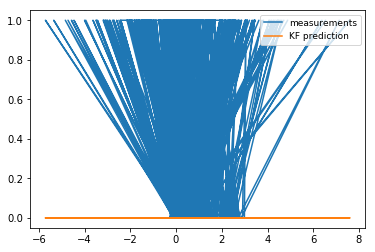

In [80]:
import matplotlib.pyplot as plt
plt.plot(X, y, label="measurements"); 
plt.plot(X, yt, label="KF prediction");
# plt.fill_between(xM, yM - yE, yM + yE, label="band", alpha = 0.2)
plt.legend(loc='upper right', prop={'size': 9})

plt.show()

In [68]:
sklearn.metrics.f1_score([0, 1, 1], [1, 0, 1])

0.5